In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report




In [157]:
df=pd.read_csv(r"C:\Users\vikas\OneDrive\Desktop\bleder dining table\Ecommerce_Sales_Data_2024_2025.csv")


In [158]:
df.head()


,Order ID,Order Date,Customer Name,Region,City,Category,Sub-Category,Product Name,Quantity,Unit Price,Discount,Sales,Profit,Payment Mode
0,10001,2024-10-19,Kashvi Varty,South,Bangalore,Books,Non-Fiction,Non-Fiction Ipsum,2,36294,5,68958.6,10525.09,Debit Card
1,10002,2025-08-30,Advik Desai,North,Delhi,Groceries,Rice,Rice Nemo,1,42165,20,33732.0,6299.66,Debit Card
2,10003,2023-11-04,Rhea Kalla,East,Patna,Kitchen,Juicer,Juicer Odio,4,64876,20,207603.2,19850.27,Credit Card
3,10004,2025-05-23,Anika Sen,East,Kolkata,Groceries,Oil,Oil Doloribus,5,37320,15,158610.0,36311.02,UPI
4,10005,2025-01-19,Akarsh Kaul,West,Pune,Clothing,Kids Wear,Kids Wear Quo,1,50037,10,45033.3,9050.04,Debit Card


In [159]:
df.shape

(5000, 14)

In [160]:
df.columns

Index(['Order ID', 'Order Date', 'Customer Name', 'Region', 'City', 'Category',
       'Sub-Category', 'Product Name', 'Quantity', 'Unit Price', 'Discount',
       'Sales', 'Profit', 'Payment Mode'],
      dtype='object')

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       5000 non-null   int64  
 1   Order Date     5000 non-null   object 
 2   Customer Name  5000 non-null   object 
 3   Region         5000 non-null   object 
 4   City           5000 non-null   object 
 5   Category       5000 non-null   object 
 6   Sub-Category   5000 non-null   object 
 7   Product Name   5000 non-null   object 
 8   Quantity       5000 non-null   int64  
 9   Unit Price     5000 non-null   int64  
 10  Discount       5000 non-null   int64  
 11  Sales          5000 non-null   float64
 12  Profit         5000 non-null   float64
 13  Payment Mode   5000 non-null   object 
dtypes: float64(2), int64(4), object(8)
memory usage: 547.0+ KB


In [162]:
df.describe()

,Order ID,Quantity,Unit Price,Discount,Sales,Profit
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,12500.500000,2.992600,39760.904600,10.051000,106733.204870,15941.746982
std,1443.520003,1.413133,22831.783946,7.084662,85108.208202,14897.684916
min,10001.000000,1.000000,222.000000,0.000000,264.100000,19.120000
25%,11250.750000,2.000000,20312.250000,5.000000,39766.537500,4892.295000
50%,12500.500000,3.000000,39459.500000,10.000000,83080.325000,11108.525000
75%,13750.250000,4.000000,59721.750000,15.000000,156968.587500,22467.987500
max,15000.000000,5.000000,79998.000000,20.000000,398485.000000,89688.440000


In [163]:
df.isnull().sum()

Order ID         0
Order Date       0
Customer Name    0
Region           0
City             0
Category         0
Sub-Category     0
Product Name     0
Quantity         0
Unit Price       0
Discount         0
Sales            0
Profit           0
Payment Mode     0
dtype: int64

In [164]:
df.duplicated().sum()

np.int64(0)

In [165]:
df.nunique()

Order ID         5000
Order Date        730
Customer Name    4844
Region              4
City               20
Category           10
Sub-Category       50
Product Name     3835
Quantity            5
Unit Price       4841
Discount            5
Sales            4978
Profit           4996
Payment Mode        5
dtype: int64

In [166]:
df.drop(['Customer Name','Order ID'],inplace=True,axis=1)

In [167]:
df.head()

,Order Date,Region,City,Category,Sub-Category,Product Name,Quantity,Unit Price,Discount,Sales,Profit,Payment Mode
0,2024-10-19,South,Bangalore,Books,Non-Fiction,Non-Fiction Ipsum,2,36294,5,68958.6,10525.09,Debit Card
1,2025-08-30,North,Delhi,Groceries,Rice,Rice Nemo,1,42165,20,33732.0,6299.66,Debit Card
2,2023-11-04,East,Patna,Kitchen,Juicer,Juicer Odio,4,64876,20,207603.2,19850.27,Credit Card
3,2025-05-23,East,Kolkata,Groceries,Oil,Oil Doloribus,5,37320,15,158610.0,36311.02,UPI
4,2025-01-19,West,Pune,Clothing,Kids Wear,Kids Wear Quo,1,50037,10,45033.3,9050.04,Debit Card


In [168]:
numeric_columns=['Unit Price','Discount','Sales','Profit']

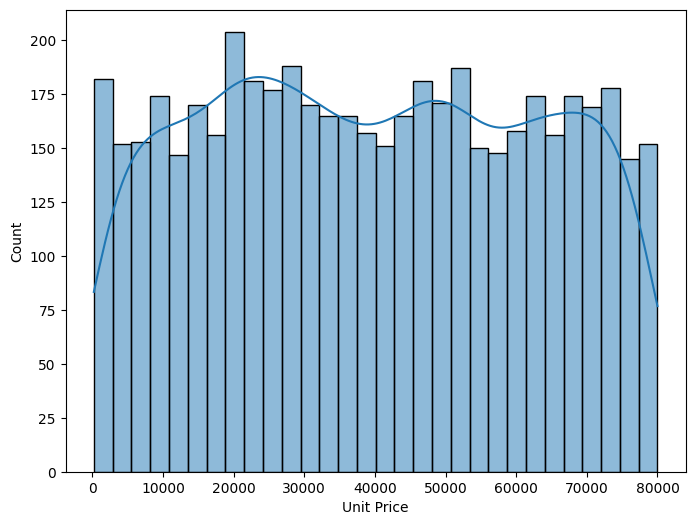

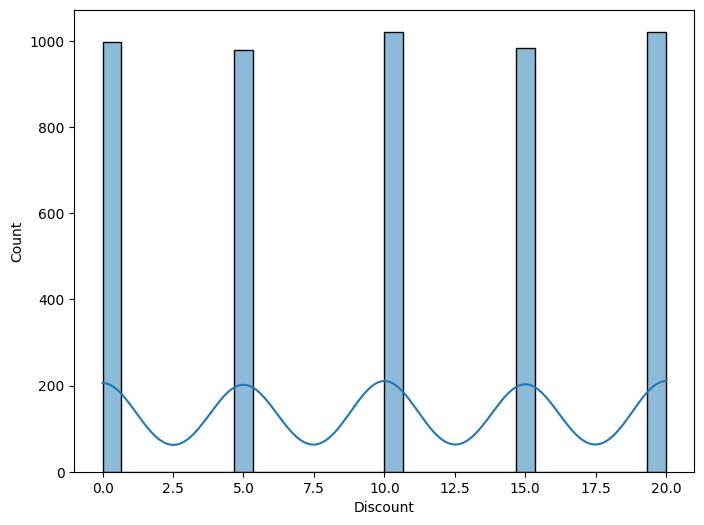

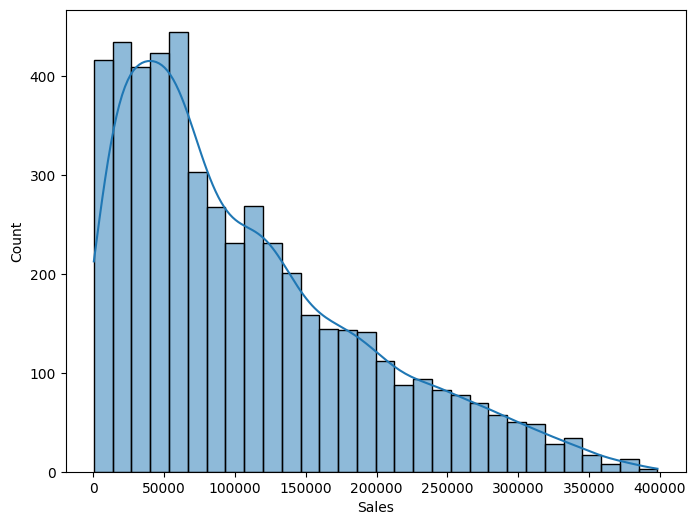

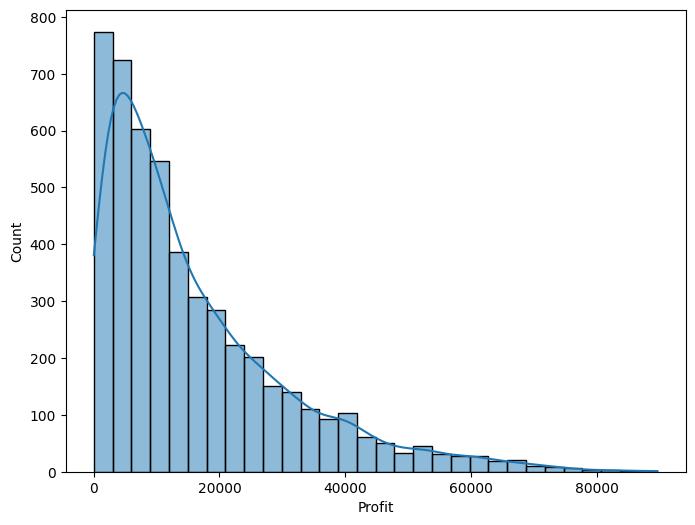

In [169]:
for col in numeric_columns:
  plt.figure(figsize=(8,6))
  sns.histplot(df[col],kde=True,bins=30)


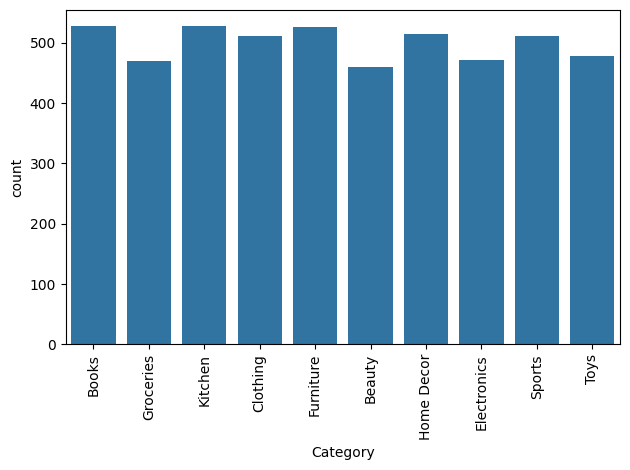

In [170]:
sns.countplot(x=df['Category'])
plt.xticks(rotation=90)
plt.tight_layout()

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49],
 [Text(0, 0, 'Non-Fiction'),
  Text(1, 0, 'Rice'),
  Text(2, 0, 'Juicer'),
  Text(3, 0, 'Oil'),
  Text(4, 0, 'Kids Wear'),
  Text(5, 0, 'Chair'),
  Text(6, 0, 'Accessories'),
  Text(7, 0, 'Biography'),
  Text(8, 0, 'Spices'),
  Text(9, 0, 'Cookware Set'),
  Text(10, 0, 'Perfume'),
  Text(11, 0, 'Vase'),
  Text(12, 0, "Women's Wear"),
  Text(13, 0, 'Laptop'),
  Text(14, 0, 'Smartwatch'),
  Text(15, 0, 'Dumbbells'),
  Text(16, 0, 'Textbook'),
  Text(17, 0, 'Refrigerator'),
  Text(18, 0, 'Wheat'),
  Text(19, 0, 'Comics'),
  Text(20, 0, 'Face Cream'),
  Text(21, 0, 'Headphones'),
  Text(22, 0, 'Foundation'),
  Text(23, 0, 'Table'),
  Text(24, 0, 'RC Car'),
  Text(25, 0, 'Sugar'),
  Text(26, 0, 'Cricket B

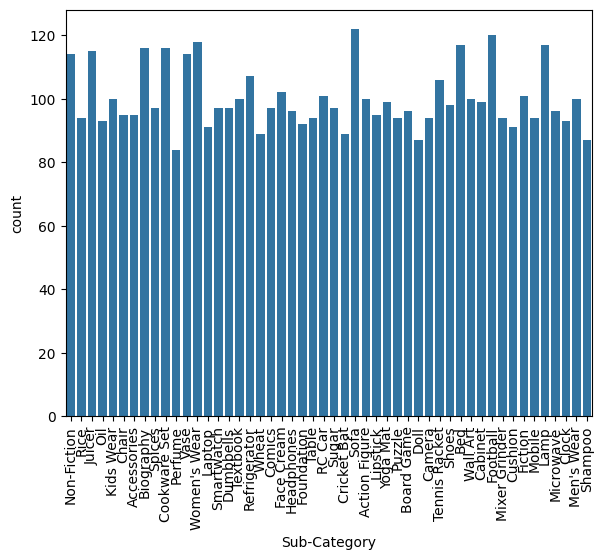

In [171]:
sns.countplot(x=df['Sub-Category'])
plt.tight_layout()
plt.xticks(rotation=90)

<Axes: xlabel='Region', ylabel='count'>

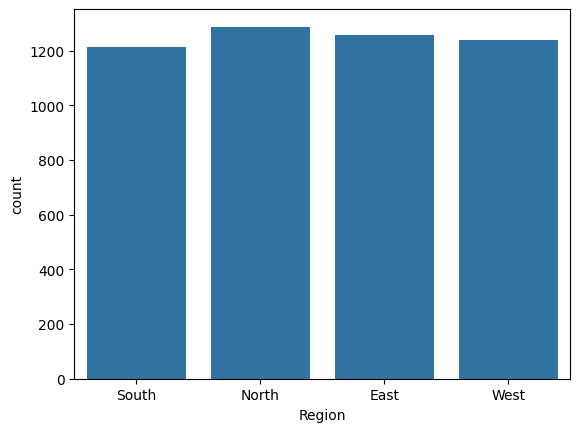

In [172]:
sns.countplot(x=df['Region'])


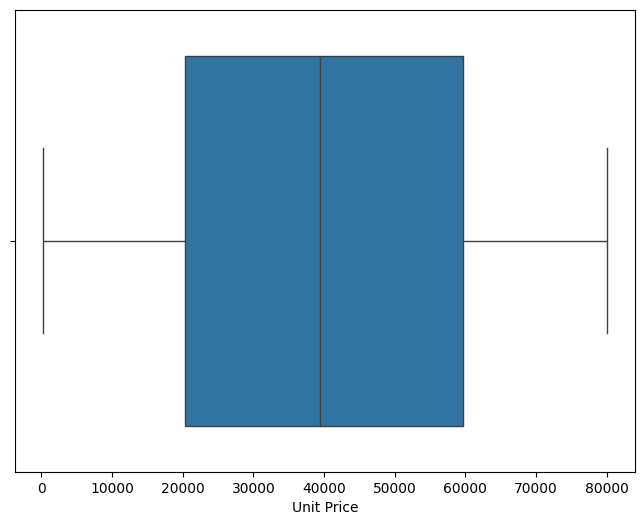

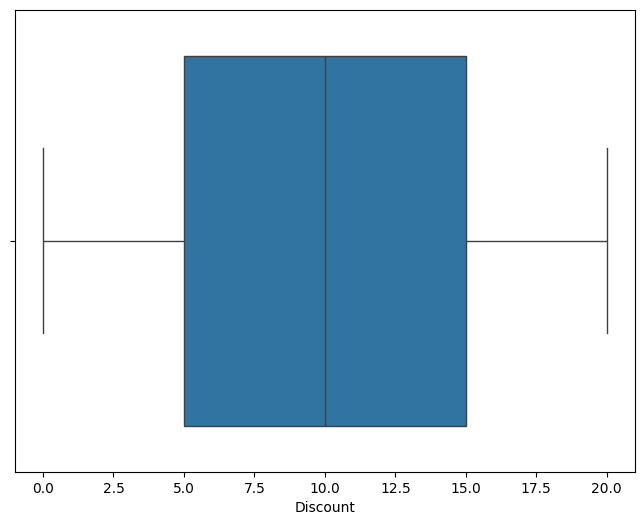

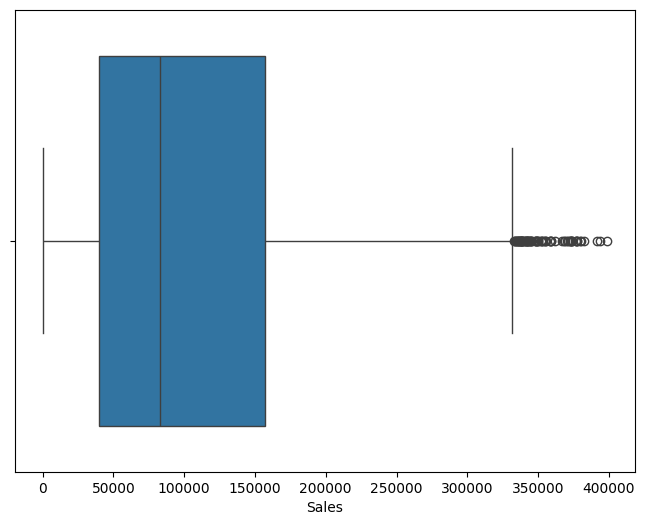

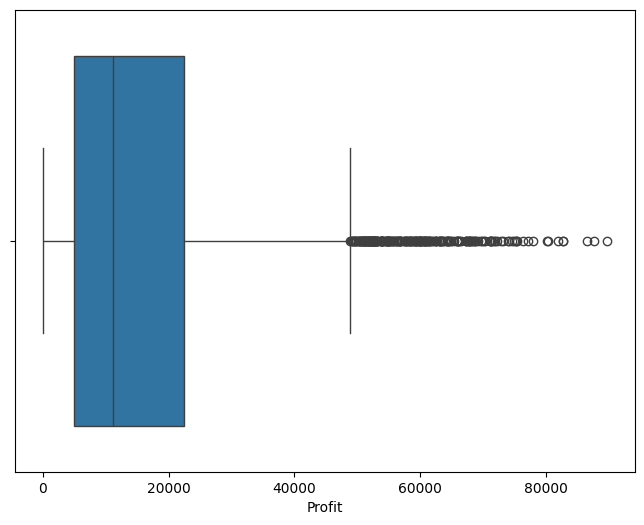

In [173]:
for col in numeric_columns:
  plt.figure(figsize=(8,6))
  sns.boxplot(x=df[col])

<Axes: >

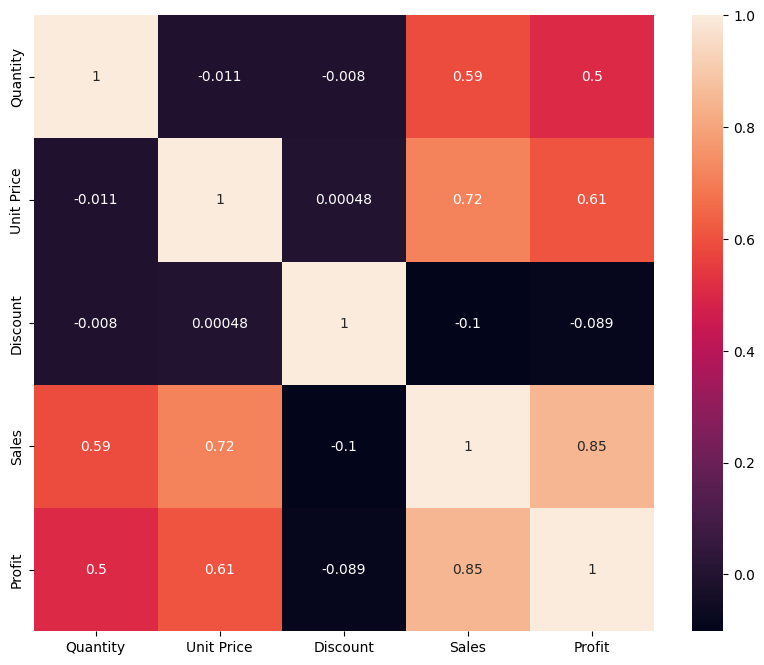

In [174]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True),annot=True)



In [175]:
df.head()

,Order Date,Region,City,Category,Sub-Category,Product Name,Quantity,Unit Price,Discount,Sales,Profit,Payment Mode
0,2024-10-19,South,Bangalore,Books,Non-Fiction,Non-Fiction Ipsum,2,36294,5,68958.6,10525.09,Debit Card
1,2025-08-30,North,Delhi,Groceries,Rice,Rice Nemo,1,42165,20,33732.0,6299.66,Debit Card
2,2023-11-04,East,Patna,Kitchen,Juicer,Juicer Odio,4,64876,20,207603.2,19850.27,Credit Card
3,2025-05-23,East,Kolkata,Groceries,Oil,Oil Doloribus,5,37320,15,158610.0,36311.02,UPI
4,2025-01-19,West,Pune,Clothing,Kids Wear,Kids Wear Quo,1,50037,10,45033.3,9050.04,Debit Card


In [176]:
df['Region'].value_counts()

Region
North    1288
East     1256
West     1241
South    1215
Name: count, dtype: int64

In [177]:
categorical_cols = ['Region', 'City', 'Category', 'Sub-Category', 'Payment Mode']

df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


In [178]:
df.head()

,Order Date,Product Name,Quantity,Unit Price,Discount,Sales,Profit,Region_North,Region_South,Region_West,...,Sub-Category_Textbook,Sub-Category_Vase,Sub-Category_Wall Art,Sub-Category_Wheat,Sub-Category_Women's Wear,Sub-Category_Yoga Mat,Payment Mode_Credit Card,Payment Mode_Debit Card,Payment Mode_Net Banking,Payment Mode_UPI
0,2024-10-19,Non-Fiction Ipsum,2,36294,5,68958.6,10525.09,False,True,False,...,False,False,False,False,False,False,False,True,False,False
1,2025-08-30,Rice Nemo,1,42165,20,33732.0,6299.66,True,False,False,...,False,False,False,False,False,False,False,True,False,False
2,2023-11-04,Juicer Odio,4,64876,20,207603.2,19850.27,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,2025-05-23,Oil Doloribus,5,37320,15,158610.0,36311.02,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,2025-01-19,Kids Wear Quo,1,50037,10,45033.3,9050.04,False,False,True,...,False,False,False,False,False,False,False,True,False,False


In [179]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['Year'] = df['Order Date'].dt.year
df['Month'] = df['Order Date'].dt.month
df['Day'] = df['Order Date'].dt.day
df['Weekday'] = df['Order Date'].dt.day_name()
df['Quarter'] = df['Order Date'].dt.quarter
df['Is_Weekend'] = df['Order Date'].dt.weekday >= 5
df = pd.get_dummies(df, columns=['Weekday', 'Is_Weekend'], drop_first=True)
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)
df = df.drop(['Order Date'], axis=1)


In [180]:
df.head()

,Product Name,Quantity,Unit Price,Discount,Sales,Profit,Region_North,Region_South,Region_West,City_Amritsar,...,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday,Is_Weekend_True,Month_sin,Month_cos,Day_sin,Day_cos
0,Non-Fiction Ipsum,2,36294,5,68958.6,10525.09,False,True,False,False,...,True,False,False,False,False,True,-0.866025,0.500000,-0.651372,-0.758758
1,Rice Nemo,1,42165,20,33732.0,6299.66,True,False,False,False,...,True,False,False,False,False,True,-0.866025,-0.500000,-0.201299,0.979530
2,Juicer Odio,4,64876,20,207603.2,19850.27,False,False,False,False,...,True,False,False,False,False,True,-0.500000,0.866025,0.724793,0.688967
3,Oil Doloribus,5,37320,15,158610.0,36311.02,False,False,False,False,...,False,False,False,False,False,False,0.500000,-0.866025,-0.998717,-0.050649
4,Kids Wear Quo,1,50037,10,45033.3,9050.04,False,False,True,False,...,False,True,False,False,False,True,0.500000,0.866025,-0.651372,-0.758758


In [181]:

bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)


In [182]:
df['Product_Avg_Sales'] = df.groupby('Product Name')['Sales'].transform('mean')
df['Product_Avg_Profit'] = df.groupby('Product Name')['Profit'].transform('mean')
df['Product_Order_Count'] = df.groupby('Product Name')['Quantity'].transform('count')


In [183]:
df = df.drop('Product Name', axis=1)


In [184]:
df.head()

,Quantity,Unit Price,Discount,Sales,Profit,Region_North,Region_South,Region_West,City_Amritsar,City_Bangalore,...,Weekday_Tuesday,Weekday_Wednesday,Is_Weekend_True,Month_sin,Month_cos,Day_sin,Day_cos,Product_Avg_Sales,Product_Avg_Profit,Product_Order_Count
0,2,36294,5,68958.6,10525.09,0,1,0,0,1,...,0,0,1,-0.866025,0.500000,-0.651372,-0.758758,178956.800000,25479.505000,2
1,1,42165,20,33732.0,6299.66,1,0,0,0,0,...,0,0,1,-0.866025,-0.500000,-0.201299,0.979530,40187.450000,6750.535000,2
2,4,64876,20,207603.2,19850.27,0,0,0,0,0,...,0,0,1,-0.500000,0.866025,0.724793,0.688967,91628.666667,10663.603333,3
3,5,37320,15,158610.0,36311.02,0,0,0,0,0,...,0,0,0,0.500000,-0.866025,-0.998717,-0.050649,158610.000000,36311.020000,1
4,1,50037,10,45033.3,9050.04,0,0,1,0,0,...,0,0,1,0.500000,0.866025,-0.651372,-0.758758,40532.850000,6372.065000,2


In [185]:
X=df.drop('Sales',axis=1)
y=df['Sales']

In [186]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)


In [190]:
import xgboost


ImportError: cannot import name 'make_jcargs' from 'xgboost.core' (c:\Users\vikas\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py)

In [ ]:
# -------------------------------
 
import optuna
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np

# Optional CatBoost
try:
    import catboost as cb
    CATBOOST_INSTALLED = True
except:
    CATBOOST_INSTALLED = False
    print("CatBoost not installed, skipping it.")

# -------------------------------

def objective(trial):
    # Available models
    models = ["DecisionTree", "RandomForest", "XGBoost", "LightGBM"]
    if CATBOOST_INSTALLED:
        models.append("CatBoost")

    model_name = trial.suggest_categorical("model", models)

    if model_name == "DecisionTree":
        max_depth = trial.suggest_int("dt_max_depth", 3, 20)
        min_samples_split = trial.suggest_int("dt_min_samples_split", 2, 20)
        model = DecisionTreeRegressor(max_depth=max_depth,
                                      min_samples_split=min_samples_split,
                                      random_state=42)

    elif model_name == "RandomForest":
        n_estimators = trial.suggest_int("rf_n_estimators", 50, 500)
        max_depth = trial.suggest_int("rf_max_depth", 3, 20)
        min_samples_split = trial.suggest_int("rf_min_samples_split", 2, 20)
        model = RandomForestRegressor(n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      min_samples_split=min_samples_split,
                                      n_jobs=-1,
                                      random_state=42)

    elif model_name == "XGBoost":
        n_estimators = trial.suggest_int("xgb_n_estimators", 50, 500)
        max_depth = trial.suggest_int("xgb_max_depth", 3, 15)
        learning_rate = trial.suggest_float("xgb_lr", 0.01, 0.3)
        subsample = trial.suggest_float("xgb_subsample", 0.5, 1.0)
        model = xgb.XGBRegressor(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 learning_rate=learning_rate,
                                 subsample=subsample,
                                 n_jobs=-1,
                                 random_state=42,
                                 tree_method='hist')

    elif model_name == "LightGBM":
        n_estimators = trial.suggest_int("lgb_n_estimators", 50, 500)
        max_depth = trial.suggest_int("lgb_max_depth", 3, 20)
        learning_rate = trial.suggest_float("lgb_lr", 0.01, 0.3)
        num_leaves = trial.suggest_int("lgb_num_leaves", 20, 150)
        model = lgb.LGBMRegressor(n_estimators=n_estimators,
                                  max_depth=max_depth,
                                  learning_rate=learning_rate,
                                  num_leaves=num_leaves,
                                  n_jobs=-1,
                                  random_state=42)

    else:  # CatBoost
        n_estimators = trial.suggest_int("cb_n_estimators", 50, 500)
        max_depth = trial.suggest_int("cb_max_depth", 3, 10)
        learning_rate = trial.suggest_float("cb_lr", 0.01, 0.3)
        model = cb.CatBoostRegressor(iterations=n_estimators,
                                     depth=max_depth,
                                     learning_rate=learning_rate,
                                     silent=True,
                                     random_state=42)

    # -------------------------------
    # Train & evaluate
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

# -------------------------------

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300, show_progress_bar=True)

# -------------------------------

print("Best RMSE:", study.best_value)
print("Best model & hyperparameters:", study.best_trial.params)


ImportError: cannot import name 'make_jcargs' from 'xgboost.core' (c:\Users\vikas\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py)

In [ ]:
from catboost import CatBoostRegressor

# -------------------------------
# Best hyperparameters
best_params = {
    'iterations': 496,
    'depth': 6,
    'learning_rate': 0.1327407810411538,
    'random_state': 42,

}
model = CatBoostRegressor(**best_params)
model.fit(X_train, y_train)
preds = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE:", rmse)

In [ ]:
# Predict on same dataset (ya alag test set agar available ho)
preds = model.predict(X_test)

# Evaluate RMSE / R2
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print("RMSE:", rmse)
print("R2 Score:", r2)


In [ ]:
from google.colab import output
output.clear()  # removes widget metadata traces


In [ ]:
pip install xgboost lightgbm catboost optuna